In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import os
import numpy as np
import pandas as pd

In [2]:
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import cv2
from pycocotools.coco import COCO
class CustomDataset(datasets.VisionDataset):
    def __init__(self, root, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms)
        self.coco = COCO(os.path.join(root, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [4]:
#A quoi ca sert ??
def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
train_dir = '../Box-Counting-5/train'
test_dir = '../Box-Counting-5/test'
valid_dir = '../Box-Counting-5/valid'

# Define datasets and dataloaders for train, test, and validation
train_dataset = CustomDataset(root=train_dir, transforms=get_transforms(True))
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)

test_dataset = CustomDataset(root=test_dir, transforms=get_transforms())
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=collate_fn)

valid_dataset = CustomDataset(root=valid_dir, transforms=get_transforms())
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [7]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
num_classes = 4 + 1 #Background

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


/home/nicolastovantrang/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nicolastovantrang/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Test avec une seul image

In [8]:
images,targets = next(iter(train_dataloader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)


In [9]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

device is cuda:0


100%|██████████| 26/26 [00:06<00:00,  4.14it/s]


Epoch 0, lr: 0.001000, loss: 0.095103, loss_classifier: 0.032665, loss_box: 0.060401, loss_rpn_box: 0.001877, loss_object: 0.000159


100%|██████████| 26/26 [00:06<00:00,  4.13it/s]


Epoch 1, lr: 0.001000, loss: 0.092305, loss_classifier: 0.033799, loss_box: 0.056650, loss_rpn_box: 0.001525, loss_object: 0.000331


100%|██████████| 26/26 [00:06<00:00,  4.16it/s]

Epoch 2, lr: 0.001000, loss: 0.107922, loss_classifier: 0.035979, loss_box: 0.069140, loss_rpn_box: 0.002142, loss_object: 0.000662


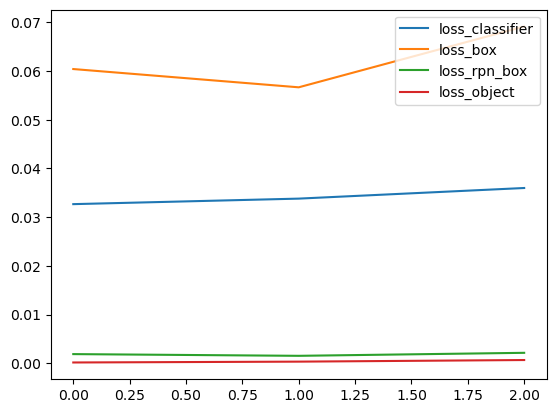

In [29]:
from tqdm import tqdm # progress bar

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is {}".format(device))

num_epochs = 100

avg_loss_classifier = []
avg_loss_box = []
avg_loss_rpn_box = []
avg_loss_object = []

# Train the model
for epoch in range(num_epochs):
    
    model = model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []
    
    for images, target in tqdm(train_dataloader):
        optimizer.zero_grad()
        
        images,targets = next(iter(train_dataloader))
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        losses.backward()
        optimizer.step()

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    avg_loss_classifier.append(all_losses_dict['loss_classifier'].mean())
    avg_loss_box.append(all_losses_dict['loss_box_reg'].mean())
    avg_loss_rpn_box.append(all_losses_dict['loss_rpn_box_reg'].mean())
    avg_loss_object.append(all_losses_dict['loss_objectness'].mean())
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
            epoch, optimizer.param_groups[0]['lr'],
            np.mean(all_losses),
            all_losses_dict['loss_classifier'].mean(),
            all_losses_dict['loss_box_reg'].mean(),
            all_losses_dict['loss_rpn_box_reg'].mean(),
            all_losses_dict['loss_objectness'].mean()
        ))

# Affichage des courbes
import matplotlib.pyplot as plt
plt.plot(avg_loss_classifier, label='loss_classifier')
plt.plot(avg_loss_box, label='loss_box')
plt.plot(avg_loss_rpn_box, label='loss_rpn_box')
plt.plot(avg_loss_object, label='loss_object')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [28]:
# Save the trained model
torch.save(model.state_dict(), '../Box-Counting-5/fine_tuned_rcnn_model.pth')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
labels predicted and ground truth tensor([1, 1, 1, 1, 1], device='cuda:0') tensor([3, 3, 3, 3])
['Box4G', 'Box4G', 'Box4G', 'Box4G', 'Box4G']
tensor([0.9964, 0.9959, 0.9941, 0.4797, 0.1081], device='cuda:0')


/tmp/ipykernel_25810/1898762823.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(img * 255, dtype=torch.uint8)


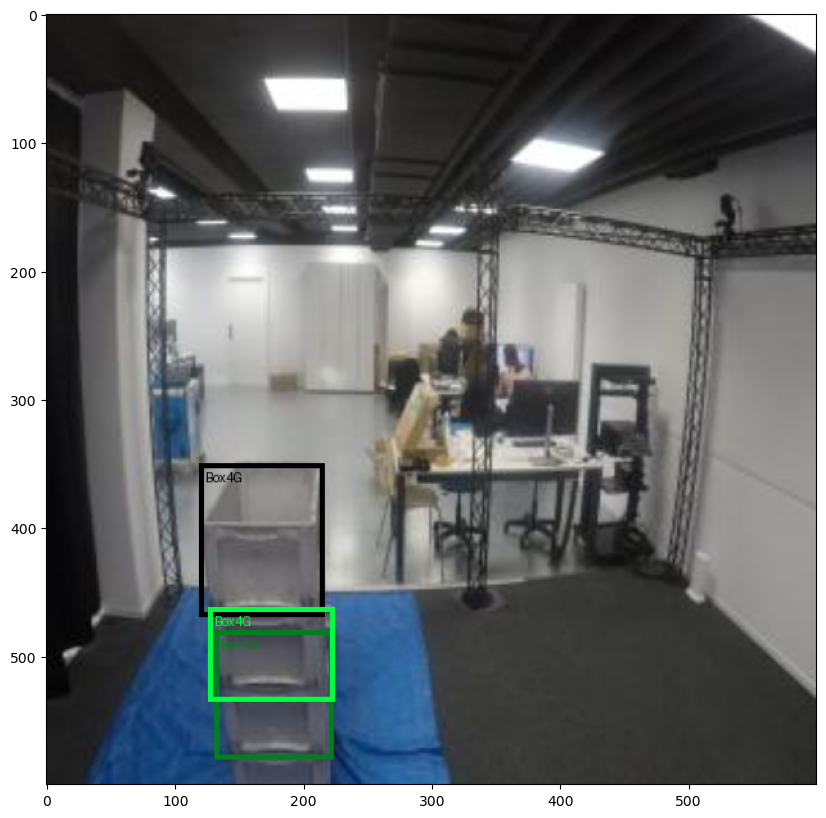

labels predicted and ground truth tensor([1, 1, 1, 1], device='cuda:0') tensor([3, 3, 3, 3])
['Box4G', 'Box4G', 'Box4G', 'Box4G']
tensor([0.9992, 0.9990, 0.9986, 0.9982], device='cuda:0')


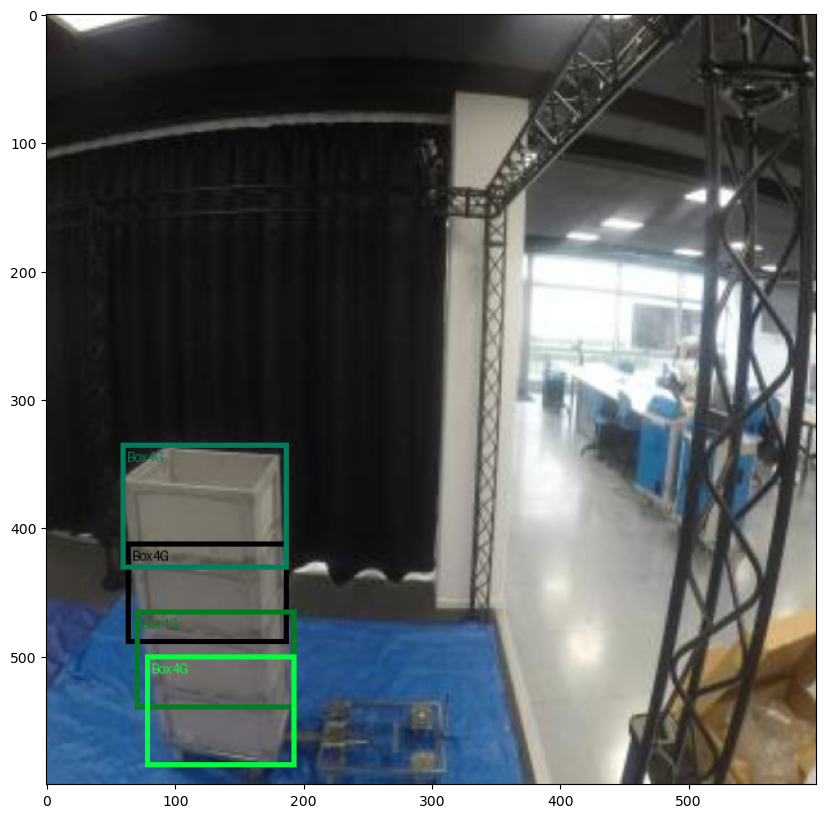

labels predicted and ground truth tensor([3, 3, 3, 3], device='cuda:0') tensor([3, 3, 3, 3])
['BoxB4', 'BoxB4', 'BoxB4', 'BoxB4']
tensor([0.9993, 0.9989, 0.9989, 0.9987], device='cuda:0')


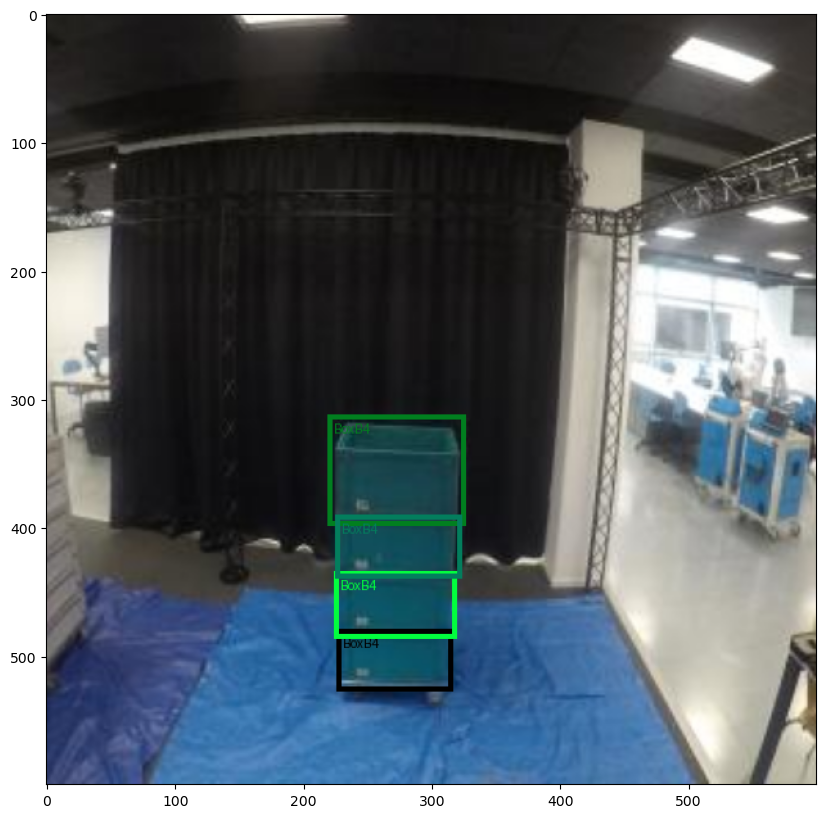

labels predicted and ground truth tensor([1, 1, 1, 1, 1], device='cuda:0') tensor([3, 3, 3, 3])
['Box4G', 'Box4G', 'Box4G', 'Box4G', 'Box4G']
tensor([0.9995, 0.9995, 0.9992, 0.9990, 0.5667], device='cuda:0')


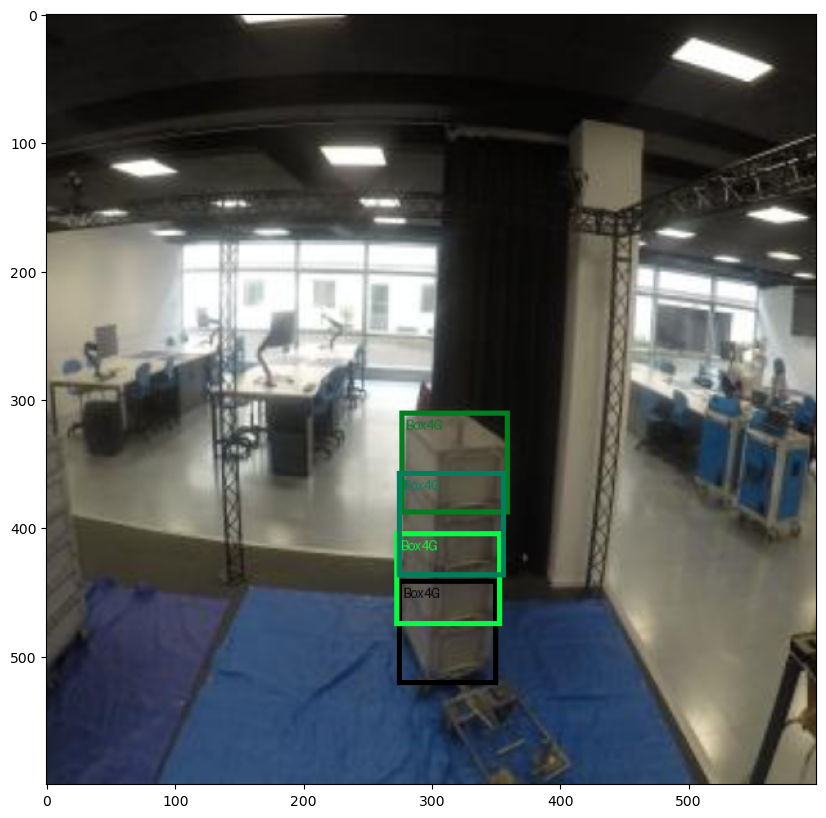

labels predicted and ground truth tensor([3, 3, 3, 3, 4, 2, 2, 2, 4, 4, 2, 4, 4, 2, 2, 4, 2, 2, 2, 4, 2, 4, 3, 4,
        2, 3, 2, 4, 3, 4], device='cuda:0') tensor([3, 3, 3, 3])
['BoxB4', 'BoxB4', 'BoxB4', 'BoxB4', 'BoxB8', 'Box8G', 'Box8G', 'Box8G', 'BoxB8', 'BoxB8', 'Box8G', 'BoxB8', 'BoxB8', 'Box8G', 'Box8G', 'BoxB8', 'Box8G', 'Box8G', 'Box8G', 'BoxB8', 'Box8G', 'BoxB8', 'BoxB4', 'BoxB8', 'Box8G', 'BoxB4', 'Box8G', 'BoxB8', 'BoxB4', 'BoxB8']
tensor([0.9994, 0.9991, 0.9990, 0.9981, 0.9974, 0.9971, 0.9971, 0.9969, 0.9969,
        0.9964, 0.9962, 0.9958, 0.9957, 0.9948, 0.9945, 0.9943, 0.9942, 0.9933,
        0.9903, 0.9650, 0.9133, 0.9106, 0.7602, 0.4766, 0.4678, 0.2426, 0.2057,
        0.1828, 0.1755, 0.1607], device='cuda:0')


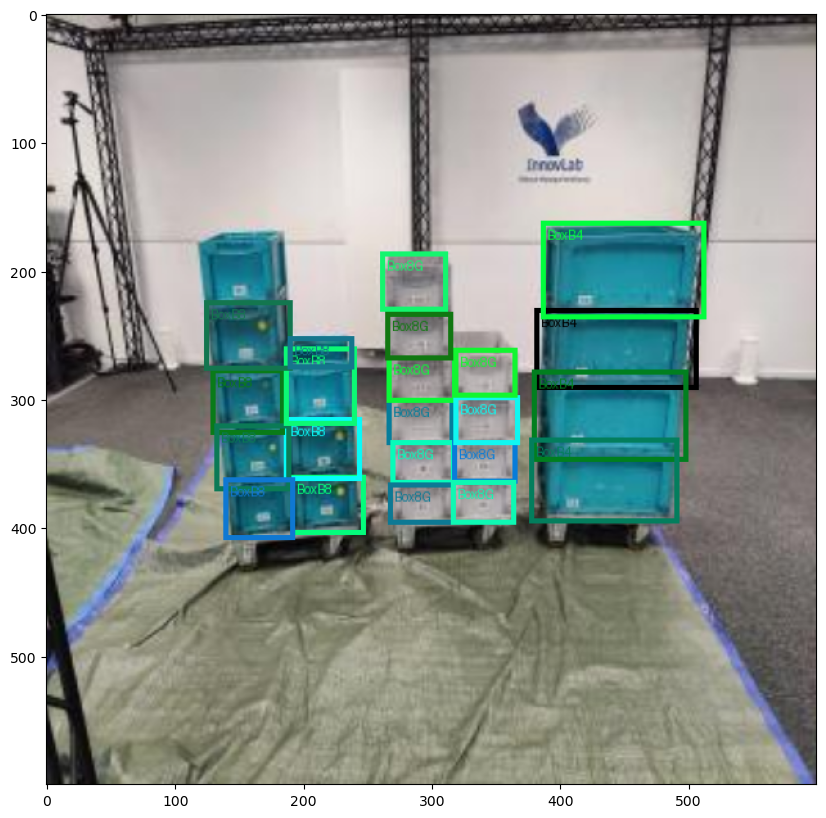

labels predicted and ground truth tensor([3, 3, 3, 3], device='cuda:0') tensor([3, 3, 3, 3])
['BoxB4', 'BoxB4', 'BoxB4', 'BoxB4']
tensor([0.9995, 0.9995, 0.9994, 0.9993], device='cuda:0')


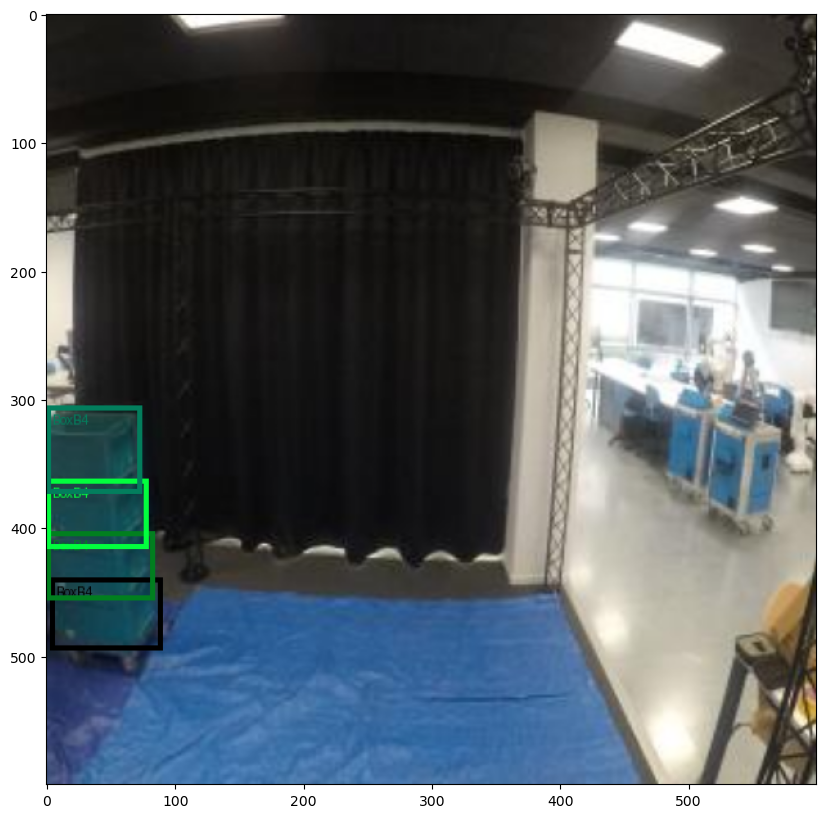

labels predicted and ground truth tensor([3, 3, 3, 3], device='cuda:0') tensor([3, 3, 3, 3])
['BoxB4', 'BoxB4', 'BoxB4', 'BoxB4']
tensor([0.9991, 0.9991, 0.9988, 0.9983], device='cuda:0')


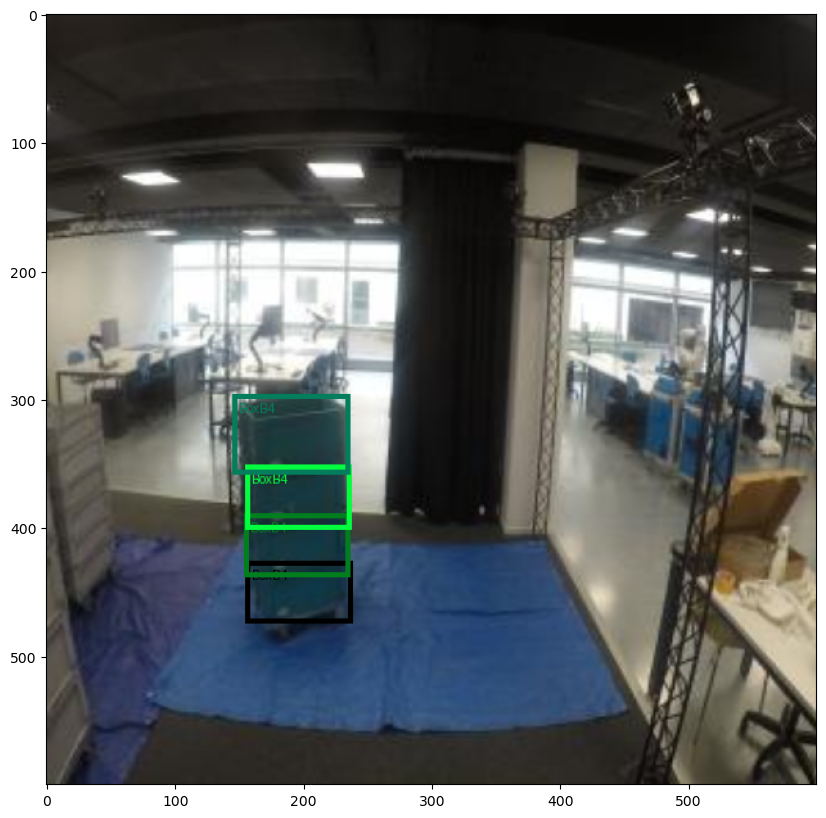

Average Precision score:  0.9194968342781067


In [27]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
#Avoir le nom des classes
dataset_path = '../Box-Counting-5'
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories
classes = [i[1]['name'] for i in categories.items()]

avg_score = 0

model.eval()
torch.cuda.empty_cache()
for img, _ in test_dataset:
    with torch.no_grad():
        prediction = model([img.to(device)])
        pred = prediction[0]
        print("labels predicted and ground truth", pred['labels'], target['labels'])
        print([classes[i] for i in pred['labels'].tolist()])
        print(pred['scores'])


        # Average Precision score for the model
        avg_score += torch.mean(pred['scores']).item()


    img_int = torch.tensor(img * 255, dtype=torch.uint8)
    fig = plt.figure(figsize=(14, 10))
    plt.imshow(draw_bounding_boxes(img_int,
        pred['boxes'][pred['scores'] > 0.8],
        [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
    ).permute(1, 2, 0))

    plt.show()

print("Average Precision score: ", avg_score / len(test_dataset))



In [22]:
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 493869, done.
remote: Counting objects: 100% (7479/7479), done.
remote: Compressing objects: 100% (459/459), done.
remote: Total 493869 (delta 7039), reused 7431 (delta 7006), pack-reused 486390
Receiving objects: 100% (493869/493869), 960.83 MiB | 29.40 MiB/s, done.
Resolving deltas: 100% (460283/460283), done.
fatal: not a git repository (or any of the parent directories): .git


In [63]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is {}".format(device))

# training for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_dataloader, device=device)

device is cuda:0


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
evaluate(model, test_dataloader, device=device)

In [70]:
def get_object_detection_model(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [95]:
def apply_nms(orig_prediction, iou_thresh=0.2):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

In [84]:
# pick one image from the test set
img, target = test_dataset[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    prediction = apply_nms(prediction, iou_thresh=0.1)
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  4
real #boxes:  4


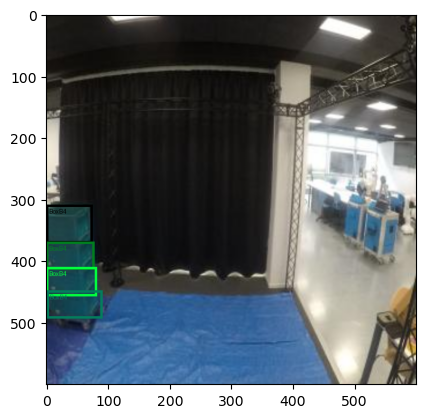

In [87]:
img_int = torch.tensor(img * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, target['boxes'], [classes[i] for i in target['labels']], width=4
).permute(1, 2, 0))

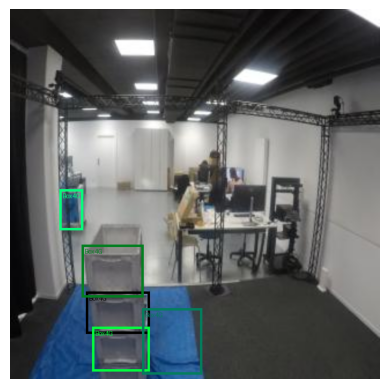

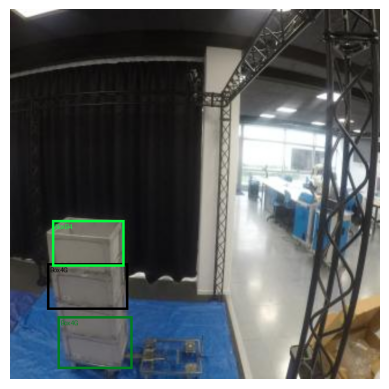

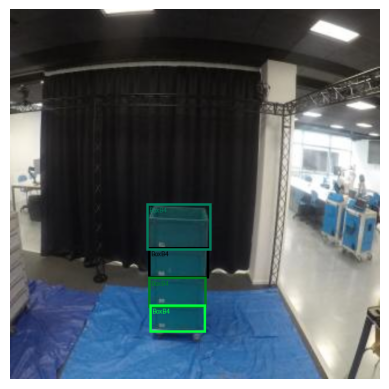

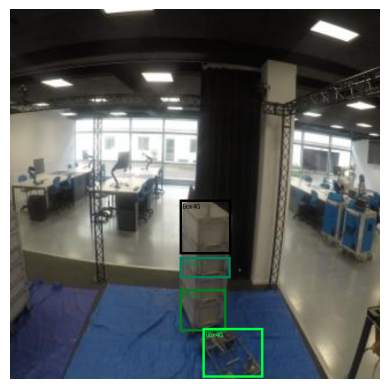

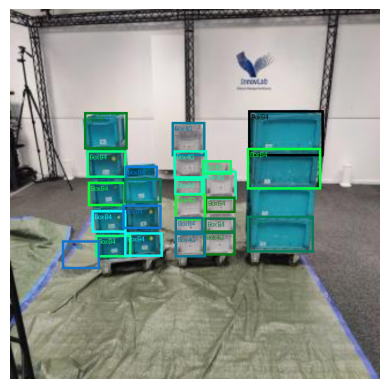

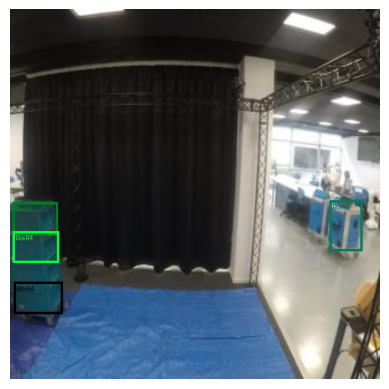

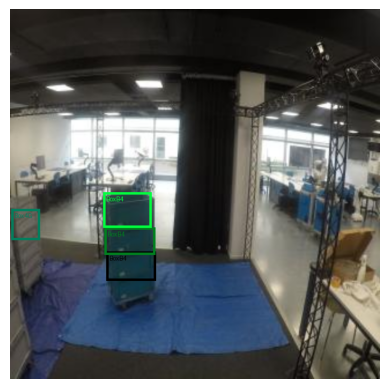

In [96]:
n = len(test_dataset)

accuracy_tot = 0

for i in range(n):
    accuracy = 0

    img, target = test_dataset[i]
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
        prediction = apply_nms(prediction, iou_thresh=0.1)
    
        
    accuracy += (len(prediction['labels']) == len(target['labels']))
    accuracy_tot += accuracy/len(prediction['labels'])

    img_int = torch.tensor(img * 255, dtype=torch.uint8)
    plt.imshow(draw_bounding_boxes(
        img_int, prediction['boxes'], [classes[i] for i in prediction['labels']], width=4
    ).permute(1, 2, 0))
    plt.axis('off')
    plt.show()


